15
Day4 not found.


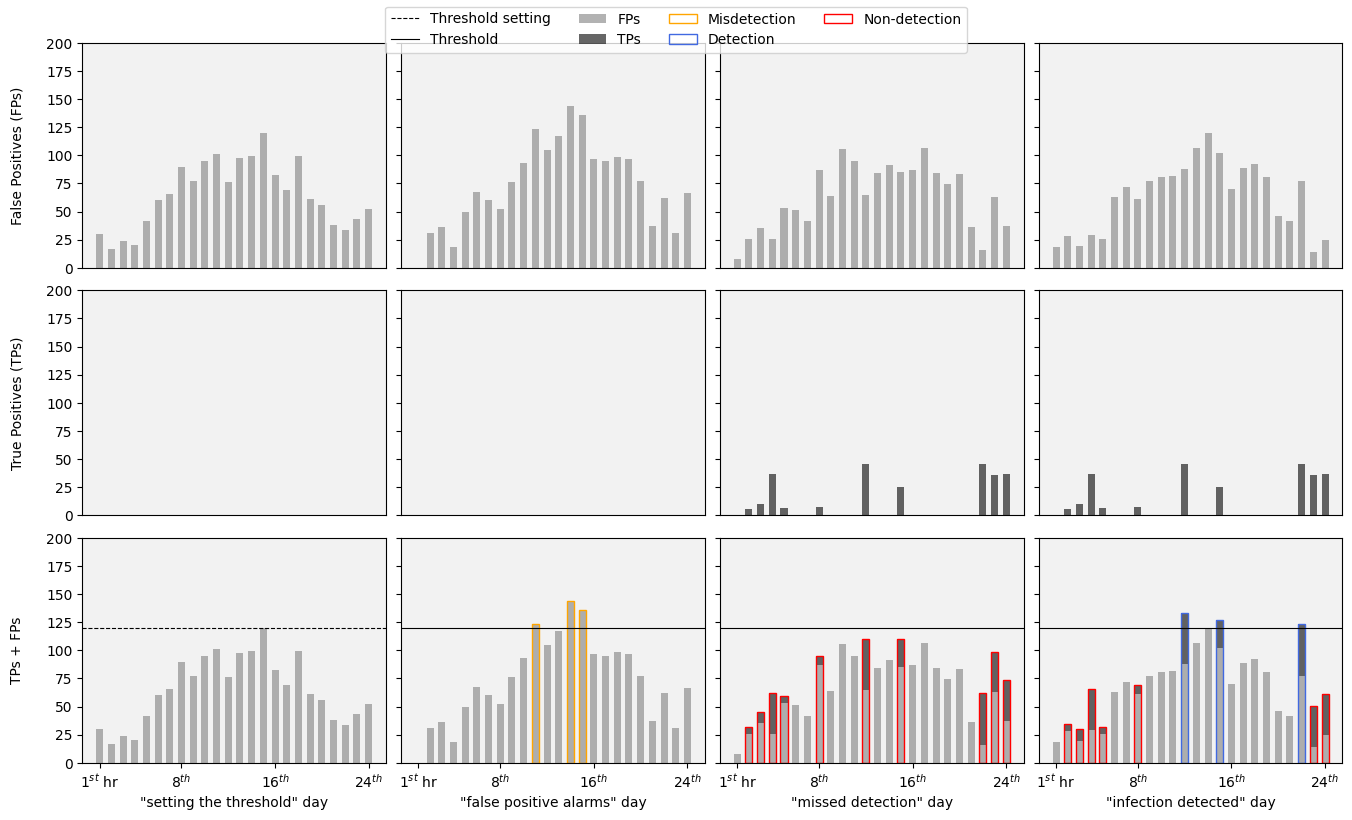

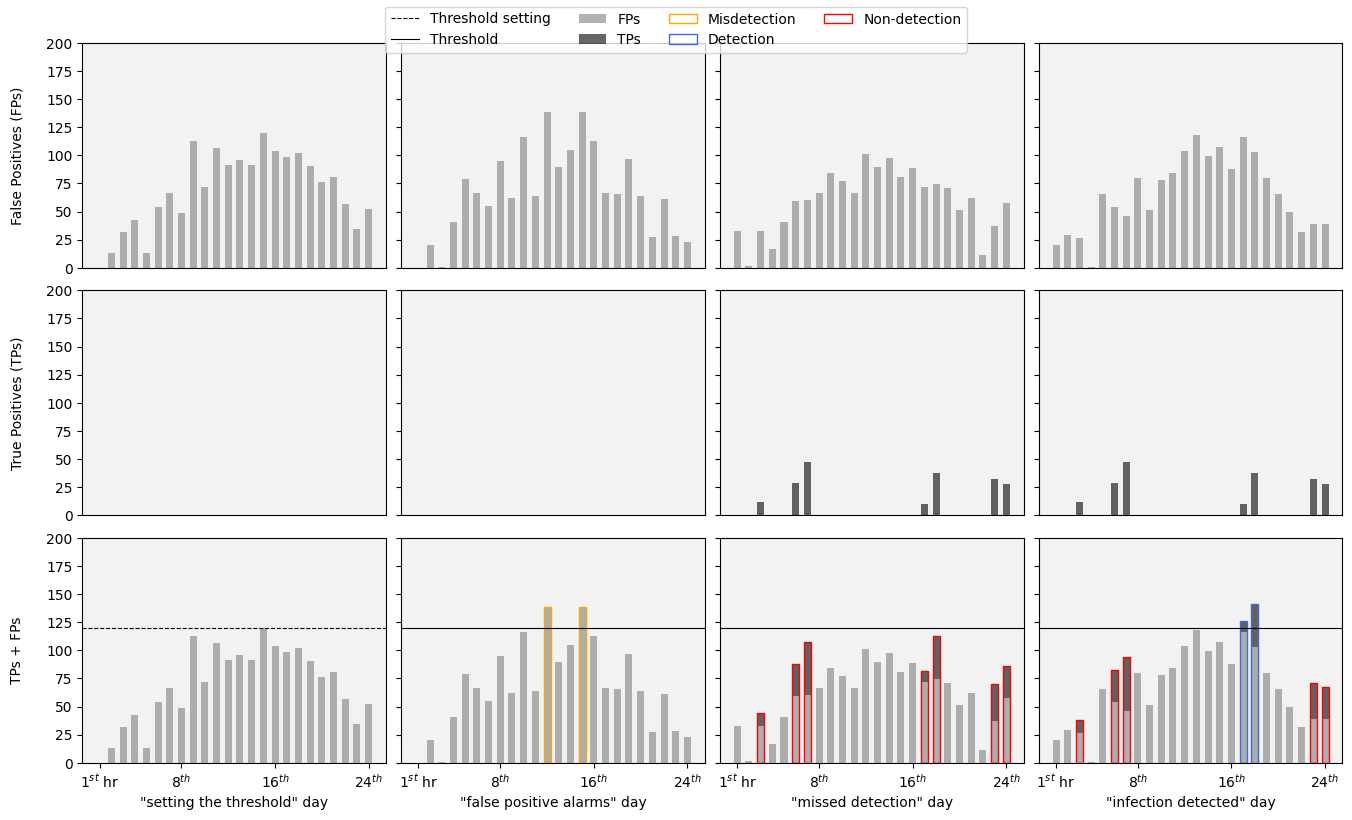

In [67]:
from dataclasses import dataclass
import math
import random
from typing import List, cast
from matplotlib import patches
from matplotlib.collections import PatchCollection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inflect
import matplotlib
from matplotlib.colors import to_rgba
import random

DF = pd.read_csv("simulated_dns_traffic.csv").pivot(index=["day","hour"], columns="variance", values="domains").reset_index()

# Genera un numero casuale tra 0 e 24
random_number = random.randint(0, 24)
print(random_number)


def traffic_model(hour, variance=0.2, std_dev=8):
    peak_hour = 13
    
    # Gaussian function centered at peak_hour
    base_traffic = np.exp(-0.8 * ((hour - peak_hour) / std_dev) ** 2)
    
    # Adding variability
    traffic = base_traffic + np.random.normal(0, variance)
    return max(0, traffic)  # Ensure non-negative values



p = inflect.engine()



FPR = 0.00216
TPR = 0.99744
@dataclass()
class Traffic:
    healthies = np.zeros(24)
    malicious = np.zeros(24)
    _fp = np.zeros(24)
    _tp = np.zeros(24)
    _tn = np.zeros(24)
    _fn = np.zeros(24)

    def fp(self):
        if (self._fp == 0).all():
            self._fp = self.healthies * FPR
        return self._fp
    
    def tp(self):
        if (self._tp == 0).all():
            self._tp = self.malicious * TPR
        return self._tp
    
    def tn(self):
        if (self._tn == 0).all():
            self._tn = self.healthies * (1 - FPR)
        return self._tn
    
    def fn(self):
        if (self._fn == 0).all():
            self._fn = self.malicious * (1 - TPR)
        return self._fn
    
    def fill(self):
        self.fp()
        self.tp()
        self.fn()
        self.tp()
        return self
    
    def copy(self):
        o = Traffic()
        o.healthies = np.copy(self.healthies)
        o.malicious = np.copy(self.malicious)
        o.fill()
        return o
    pass


def bo(NN, magn_healthy = 50e3, magn_malicious_healthies = 10):
    def healthy_traffic(magnitude): #[ 55000, 55000, 48000, 50000]
        traffic = Traffic()
        traffic.healthies = np.array([magnitude * traffic_model(hour, std_dev=8, variance=0.15) for hour in range(24)])
        return traffic
    
    def malicious_traffic(p_magnitude, n_magnitude=1): # [0, 0, 30, 50]
        traffic = Traffic()
        traffic.healthies = np.array([magn_malicious_healthies * traffic_model(hour, std_dev=18, variance=0.5) for hour in range(24) ])
        traffic.malicious = np.array([p_magnitude * traffic_model(hour, std_dev=18, variance=0.5) for hour in range(24) ])
        return traffic

    def day1():
        ht = healthy_traffic(magn_healthy)
        mt = Traffic()
        return ht.fill(), mt.fill()

    def day2(th):
        ok = False
        for i in range(10000):
            ht = healthy_traffic(magn_healthy)
            mt = Traffic()
            if ((ht.fp() - th) > 15).sum() > 1:
                ok = True
                break
            pass
        
        if not ok:
            raise Exception("Day2 not found.")

        return ht.fill(), mt.fill()

    def day3(th):
        ok = False
        for i in range(100):
            ht = healthy_traffic(magn_healthy * 0.9)
            
            for j in range(1000):
                mt = malicious_traffic(30)

                for _ in range(12):
                    mt.malicious[random.randint(0,23)] = 0
                for _ in range(8):
                    mt.malicious[random.randint(0,23)] *= 0.05

                if (((mt.tp() + ht.fp()) - th) >= -5).sum() == 0:
                    ok = True
                    break
                pass
            pass

        if not ok:
            raise Exception("Day3 not found.")

        return ht.fill(), mt.fill()

    def day4(mt: Traffic, th):
        ok = False
        for i in range(1000):
            ht = healthy_traffic(magn_healthy * 0.95)

            if (((mt.tp() + ht.fp()) - th) >= 5).sum() > 1:
                if ((ht.fp() - th) > 0).sum() == 0:
                    ok = True
                    break
            pass
    
        if not ok:
            raise Exception("Day4 not found.")
    
        return ht.fill(), mt

    days = 4
    
    width = 0.6
    for nn in range(NN):
        hours = np.arange(24)
        
        ht1,_ = day1()
        th = ht1.fp().max()

        try:
            ht2,mt2 = day2(th)
            ht3,mt3 = day3(th)
            ht4,mt4 = day4(mt3, th)
        except Exception as e:
            print(e)
            continue

        fig, axs = plt.subplots(3, days, figsize=(20,4), sharey="row")
        axs = cast(np.ndarray, axs)
    
        traffic_days = [  
            (ht1,mt2),
            (ht2,mt2),
            (ht3,mt3),
            (ht4,mt4)
        ]

        ymax = math.ceil(max([ ht.fp().max() + mt.tp().max() for ht, mt in traffic_days]) / 100) * 100

        for day in range(days):

            # if wrong_false_alarms[day].sum() > 0 and wrong_false_alarms[day].sum() > 0:
            #     legend_axes = day

            healthycolor = np.full((24, 4), np.array(to_rgba('grey', 0), dtype=np.float64), dtype=np.float64)
            maliciouscolor = np.full((24, 4), np.array(to_rgba('black', 0), dtype=np.float64), dtype=np.float64)
            
            negativemask = np.full((24, 4), np.array([0,0,0,0.2]), dtype=np.float64)
            positivemask = np.full((24, 4), np.array([0,0,0,0.6]), dtype=np.float64)

            background_color = to_rgba('gray', 0.1)

            fff = 0
            # axs[fff, day].bar(hours, ht.healthies[:, day], bottom=0,                      width=width, color=healthycolor + negativemask, label="HT")
            # fff += 1

            # axs[fff, day].bar(hours, mt.healthies[:, day], bottom=0,                      width=width, color=healthycolor + negativemask, label="HT")
            # axs[fff, day].bar(hours, mt.malicious[:, day], bottom=mt.healthies[:, day],   width=width, color=maliciouscolor + negativemask, label="HT")
            # fff += 1


            fp = traffic_days[day][0].fp()
            tp = traffic_days[day][1].tp()
            tp[tp<5] = 0
            
            axs[0, day].bar(hours, fp, bottom=0, width=width, color=healthycolor + positivemask, label="FPs")
            axs[0, day].set_ylim(0, ymax)


            axs[1, day].bar(hours, tp, bottom=0,  width=width, color=maliciouscolor + positivemask, label="TPs")
            axs[1, day].set_ylim(0, ymax)


            axs[2, day].bar(hours, fp, bottom=0,       width=width, color=healthycolor + positivemask, label="FPs")
            axs[2, day].bar(hours, tp, bottom=fp,     width=width, color=maliciouscolor + positivemask, label="TPs")
            if tp.sum() > 0:
                alarms = ((tp > 0) & ((fp + tp) > th))
                noalarms = ((tp > 0) & ((fp + tp) <= th))
                if alarms.sum() > 0:
                    axs[2, day].bar(hours[alarms], (fp + tp)[alarms], lw=1, width=width, edgecolor='royalblue', color=to_rgba("#FFFFFF00"), label='Detection')
                if noalarms.sum() > 0:
                    axs[2, day].bar(hours[noalarms], (fp + tp)[noalarms], lw=1, width=width, edgecolor='red', color=to_rgba("#FFFFFF00"), label='Non-detection')

            alarms = ((fp) > th) & (tp == 0)
            if alarms.sum() > 0:
                axs[2, day].bar(hours[alarms], (fp + tp)[alarms], lw=1, width=width, edgecolor='orange', color=to_rgba("#FFFFFF00"), label="Misdetection")

            axs[2, day].set_ylim(0, ymax)



            # if day > 0:
            #     ax.set_yticks([])
            for i in range(3):
                axs[i, day].set_xticks([])
                axs[i, day].set_facecolor(background_color)
                # axs[i, day].legend()

            hours_labels_pos = [0, 7, 15, 23]
            hours_labels = [
                '$1^{{st}}$ hr',
                '$8^{th}$',
                '$16^{th}$',
                '$24^{th}$'
            ]
            axs[-1, day].set_xticks(hours_labels_pos, hours_labels)
            # axs[-1, day].set_xlabel('hours')


            pad = 16
            axs[0, 0].set_ylabel("False Positives (FPs)", rotation='vertical', labelpad=pad, size='medium')
            axs[1, 0].set_ylabel("True Positives (TPs)", rotation='vertical', labelpad=pad, size='medium')
            axs[2, 0].set_ylabel("TPs + FPs", rotation='vertical', labelpad=pad, size='medium')
            
            if True:
                axs[-1, day].set_xlabel([
                    "\"setting the threshold\" day",
                    "\"false positive alarms\" day",
                    "\"missed detection\" day",  
                    "\"infection detected\" day"
                ][day], size='medium')
            else:
                axs[0, day].set_title([
                    "\"setting the threshold\" day",
                    "\"false positive alarms\" day",
                    "\"missed detection\" day",  
                    "\"infection detected\" day",  
                ][day], size='medium')
        
            if day == 0:
                axs[-1, day].axhline(th, linewidth=0.8, color='black', label="Threshold setting", linestyle="--")
            else:
                axs[-1, day].axhline(th, linewidth=0.8, color='black', label="Threshold", linestyle="-")
            
            pass

        for i in range(axs.shape[0]):
            for ax in axs[i,:]:
                ax.set_ylim(axs[0,0].get_ylim())

        fig.set_size_inches(14,8)
        fig.subplots_adjust(left=0.08, top=0.95, right=0.98, bottom=0.05,
        hspace=0.1, wspace=0.05)


        ls_pos = [ 'Threshold setting', 'Threshold', 'FPs', 'TPs', 'Misdetection', 'Detection', 'Non-detection' ]
        newhs, newls = list(range(7)), list(range(7))
        for ax in fig.axes:
            hs, ls = ax.get_legend_handles_labels()
            for idxl, l in enumerate(ls):
                if l not in newls:
                    newhs[ls_pos.index(l)] = hs[idxl]
                    newls[ls_pos.index(l)] = l
                pass
        fig.legend(newhs, newls, loc='outside upper center', ncols=4)
        fig.savefig(f"bo_{nn}.pdf", bbox_inches="tight")

        nn += 1

        plt.show()
        plt.close()

        pass

bo(3, magn_healthy=50000, magn_malicious_healthies=50000)


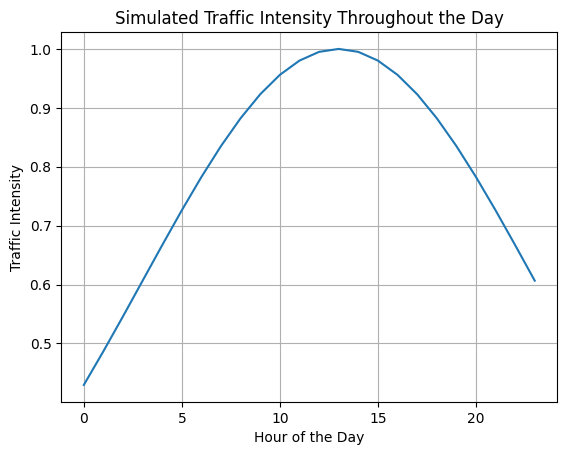

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def traffic_model(hour):
    peak_hour = 13
    std_dev = 10
    
    # Gaussian function centered at peak_hour
    traffic = np.exp(-0.5 * ((hour - peak_hour) / std_dev) ** 2)
    return traffic

# Generate data for 24 hours
hours = np.arange(24)
traffic_values = [traffic_model(hour) for hour in hours]

# Plotting the result for visualization
plt.plot(hours, traffic_values)
plt.xlabel('Hour of the Day')
plt.ylabel('Traffic Intensity')
plt.title('Simulated Traffic Intensity Throughout the Day')
plt.grid(True)
plt.show()


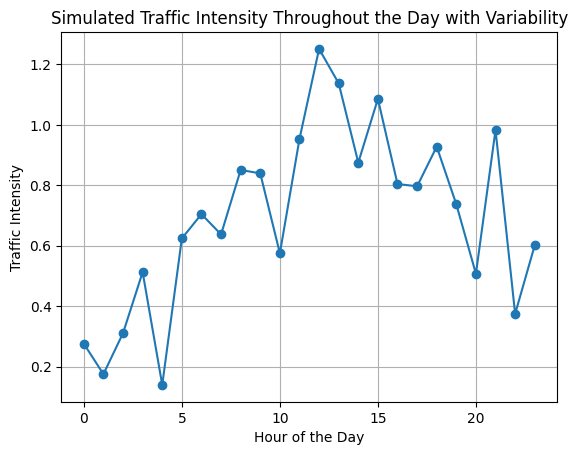

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def traffic_model(hour, variance=0.2):
    peak_hour = 13
    std_dev = 8
    
    # Gaussian function centered at peak_hour
    base_traffic = np.exp(-0.5 * ((hour - peak_hour) / std_dev) ** 2)
    
    # Adding variability
    traffic = base_traffic + np.random.normal(0, variance)
    return max(0, traffic)  # Ensure non-negative values

# Generate data for 24 hours with variance
hours = np.arange(24)
traffic_values = [traffic_model(hour) for hour in hours]

# Plotting the result for visualization
plt.plot(hours, traffic_values, marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Traffic Intensity')
plt.title('Simulated Traffic Intensity Throughout the Day with Variability')
plt.grid(True)
plt.show()


23
[np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_] []
[np.False_, np.True_, np.True_, np.False_, np.True_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_] [(1, 2, 4), (np.float64(197.3786646680871), np.float64(162.22693045424853), np.float64(216.90703668946713))]
[np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_] []
[np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, n

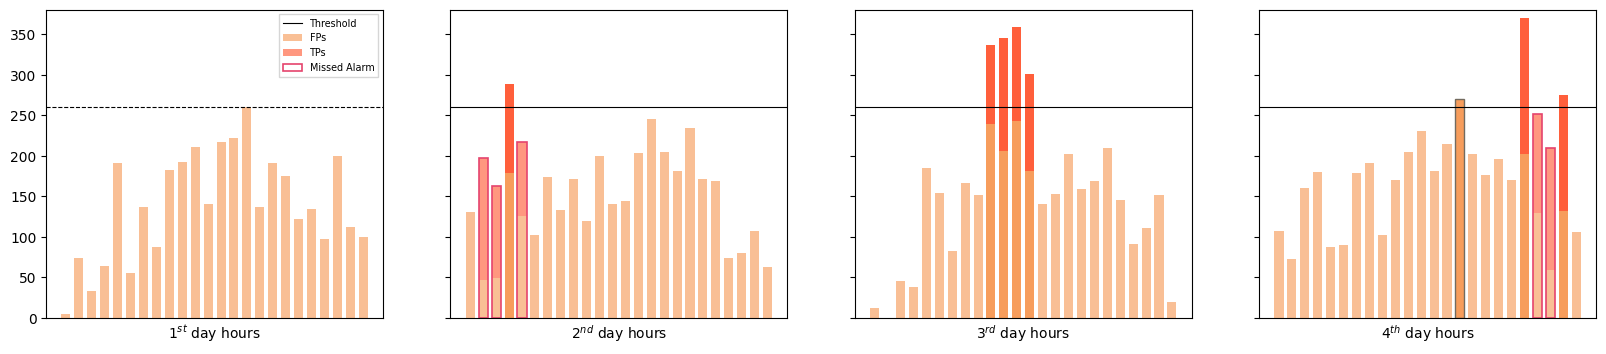

In [83]:
import random

# Genera un numero casuale tra 0 e 24
random_number = random.randint(0, 24)
print(random_number)


def traffic_model(hour, variance=0.2, std_dev=8):
    peak_hour = 13
    
    # Gaussian function centered at peak_hour
    base_traffic = np.exp(-0.5 * ((hour - peak_hour) / std_dev) ** 2)
    
    # Adding variability
    traffic = base_traffic + np.random.normal(0, variance)
    return max(0, traffic)  # Ensure non-negative values


p = inflect.engine()


def bo():
    df = DF
    
    
    FP = 200
    TP = 150
    
    days = 4
    
    hours = np.arange(24)
    fig, axs = plt.subplots(1, days, figsize=(20,4), sharey=True)
    
    FPs_days = [[],[]]
    TPs_days = [
        np.zeros((days, 24)),
        np.zeros((days, 24))
    ]

    ths = np.zeros(7)
    for day in range(days):
        FPs_days[0].append(np.array([FP * traffic_model(hour) for hour in hours]))
    for day in range(days):
        FPs_days[1].append(np.array([FP * traffic_model(hour) for hour in hours]))
        if day > 0:
            TPs_days[1][day] = (np.array([TP * traffic_model(hour, std_dev=24) for hour in hours]))
        
    
    for day in range(days):
        r = [0, 0, 8, 18][day]
        for h in range(24):
            if h <= r or h > r + 4:
                TPs_days[1][day][h] = 0
    M=0
    for day in range(days):
        for h in range(24):
            _M = (TPs_days[1][day] + FPs_days[1][day]).max()
            M = _M if M < _M else M
    
    width = 0.7
    lw=1
    th = FPs_days[1][0].max() # - FPs_days[1][0].std()
    for day in range(days):
        FPs = FPs_days[1][day]
        TPs = TPs_days[1][day]

        true_no_alarms = [ TPs[h] == 0 and FPs[h] <= th  for h in range(24) ]
        true_raised_alarms = [ (TPs[h] > 0 and ((FPs[h] + TPs[h]) > th)) for h in range(24) ]
        wrong_missed_alarms = [ (TPs[h] > 0 and ((FPs[h] + TPs[h]) <= th)) for h in range(24) ]
        wrong_false_alarms = [ (TPs[h] == 0 and (FPs[h] + TPs[h] > th)) for h in range(24) ]

        alarms = [ (FPs[h] + TPs[h]) > th for h in range(24) ]
        
        bar_true_no_alarms = list(zip(*[ (h, FPs[h] + TPs[h]) for h, a in enumerate(true_no_alarms) if a ]))
        bar_true_raised_alarms = list(zip(*[ (h, FPs[h] + TPs[h]) for h, a in enumerate(true_raised_alarms) if a ]))
        bar_wrong_missed_alarms = list(zip(*[ (h, FPs[h] + TPs[h]) for h, a in enumerate(wrong_missed_alarms) if a ]))
        bar_wrong_false_alarms = list(zip(*[ (h, FPs[h] + TPs[h]) for h, a in enumerate(wrong_false_alarms) if a ]))

        print(wrong_missed_alarms, bar_wrong_missed_alarms)

        # ax = axs[row][day]
        ax = axs[day]
        nocolor = (0,0,0,0)
        fpcolor = [(247/255, 157/255, 92/255, 0.65 if not alarms[h] else 1) for h in range(24)]
        tpcolor = [(255/255, 95/255, 59/255, 0.65 if not alarms[h] else 1) for h in range(24)]
        false_color = (115/255,107/255,96/255,1)
        missed_color = [_/255 for _ in (229,68,109)] + [1]
        ax.axhline(th, linewidth=0.8, color='black', label="Threshold", linestyle="--" if day == 0 else "-")


        ax.bar(hours, FPs, bottom=0, width=width, color=fpcolor, label="FPs")
        ax.bar(hours, TPs, bottom=FPs, width=width, linewidth=0, edgecolor=nocolor, color=tpcolor, label="TPs")
        if day > 0:
            # if bar_true_no_alarms:
            #     ax.bar(bar_true_no_alarms[0], bar_true_no_alarms[1], bottom=0, width=width, color=nocolor, linewidth=lw, edgecolor=correctcolor, label="Correct")
            # if bar_true_raised_alarms:
            #     ax.bar(bar_true_raised_alarms[0], bar_true_raised_alarms[1], bottom=0, width=width, color=nocolor, linewidth=lw, edgecolor=nocolor, label="True Alarm")
            if bar_wrong_missed_alarms:
                ax.bar(bar_wrong_missed_alarms[0], bar_wrong_missed_alarms[1], bottom=0, width=width, color=nocolor, linewidth=lw*1.2, edgecolor=missed_color, label="Missed Alarm")
            if bar_wrong_false_alarms:
                ax.bar(bar_wrong_false_alarms[0], bar_wrong_false_alarms[1], bottom=0, width=width, color=nocolor, linewidth=lw, edgecolor=false_color, label="False Alarm")


        ax.set_xticks([])
        ax.set_xlabel(f"${day+1}^{{{p.ordinal(day+1)[1:]}}}$ day hours")
        ax.set_ylim(0,M + 10)
        pass
    
    handles, labels = axs[1].get_legend_handles_labels()

    axs[0].legend(handles, labels, fontsize="x-small", fancybox=False)
    
    fig.savefig("bo.pdf", bbox_inches="tight")
    return fig
_ = bo()


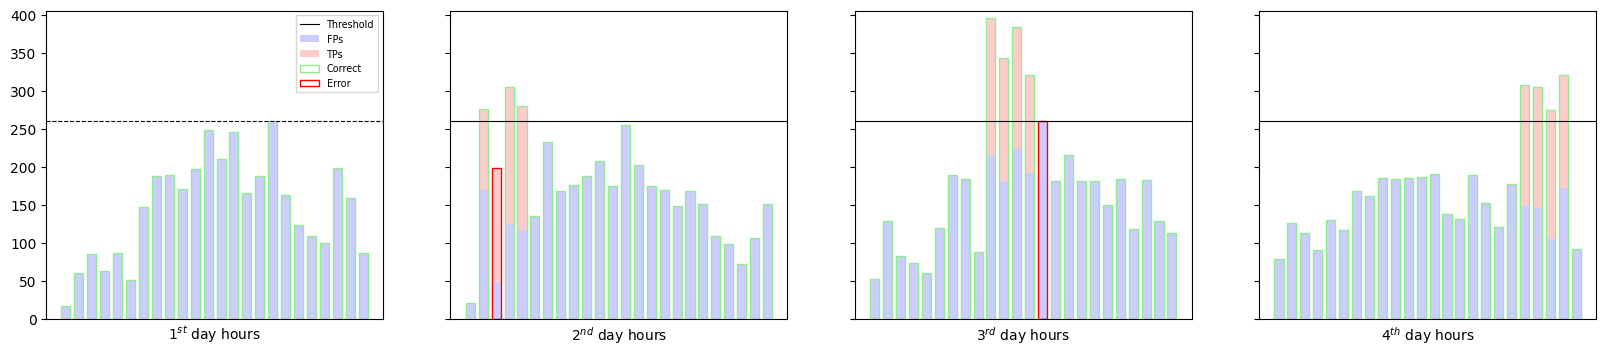